In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import os, sys, warnings
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt, ticker
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb
import catboost 
import joblib, gc

torch.manual_seed(0)
torch.set_num_threads(16)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
class MLP(nn.Module):

    def __init__(self,  fc1_num, fc2_num, fc3_num, dropout_rate):
        super(MLP, self).__init__()
        self.fc1_num = fc1_num
        self.fc2_num = fc2_num
        self.fc3_num = fc3_num

        # 两个全连接层
        self.fc1 = nn.Linear(fc1_num, fc2_num) # 702 -> 30
        self.fc2 = nn.Linear(fc2_num, 1)
        # self.fc3 = nn.Linear(fc3_num, 1)# 30 -> 1
        # 激活函数
        self.relu = nn.ReLU()
        # dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        # 使用 xavier 的均匀分布对 weights 进行初始化
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        # 使用正态分布对 bias 进行初始化
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, data):
        data = self.flatten(data)
        data = self.fc1(data) # N*30
        data = self.relu(data)
        data = self.dropout(data)
        data = self.fc2(data)
        # data = self.relu(data)
        # data = self.dropout(data)
        # data = self.fc3(data)
        # 线性激活函数，无需再进行激活
        data = data.to(torch.float)

        return data


class FactorData():

    def __init__(self, train_x, train_y):
        self.len = len(train_x)
        self.x_data = train_x
        self.y_data = train_y

    def __getitem__(self, index):
        """
        指定读取数据的方式：根据索引 index 返回 dataset[index]

        """
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


In [3]:
def prepare_data(train_parquet, stock_labels, skip_cols, n_split=5):
    
    df = pd.read_parquet(train_parquet)
    df = df[~df['target'].isnull()].reset_index(drop=True)
    df = df.drop(columns=['row_id', 'time_id'])
    df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})
    
    feature_cols = [x for x in df.columns if x not in ['target']+skip_cols]
    category_cols = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag', 'stock_label']

    df = df[df['stock_label'].isin(stock_labels)].reset_index(drop=True)
    
    print(df.shape)
    print(f"Stock labels: {stock_labels}")
    print(f"Trading days: {df['date_id'].nunique()}")
    print(f"Stocks: {df['stock_id'].nunique()}")
    print("Number of features:", len(feature_cols))
    print("Number of category features:", len(category_cols))
    
    scale_cols = [x for x in feature_cols if x not in category_cols]
    scaler = StandardScaler().fit(df[scale_cols])
    
    df[scale_cols] = scaler.transform(df[scale_cols])
    
    has_invalids = df.isnull().values.any() & np.isinf(df.values).any()
    
    if has_invalids:
        print("df has NaNs or Infs")
        print(df.isnull().sum())
        print(df.isinf().sum())
        sys.exit(1)
        
    dates_list = df['date_id'].unique()
    
    k_fold = KFold(n_splits=n_split, shuffle=False, random_state=None)
    kf_split = k_fold.split(dates_list)
    
    datasets = {}
    
    for fold, (train_idx, valid_idx) in enumerate(kf_split):
        
        print(f"Fold {fold+1}")
        fold_start = time()
        
        train_dates = dates_list[train_idx]
        
        half_valid = int(len(valid_idx)/2)
        valid_dates_1 = dates_list[valid_idx[:half_valid]]
        valid_dates_2 = dates_list[valid_idx[half_valid:]]
        
        print(f"Valid Dates 1: {valid_dates_1[0]} - {valid_dates_1[-1]}")
        print(f"Valid Dates 2: {valid_dates_2[0]} - {valid_dates_2[-1]}")
        
        # split train and valid set
        df_train_fold = df[df["date_id"].isin(train_dates)].reset_index(drop=True)
        df_valid_fold_1 = df[df["date_id"].isin(valid_dates_1)].reset_index(drop=True)
        df_valid_fold_2 = df[df["date_id"].isin(valid_dates_2)].reset_index(drop=True)
        
        print(f"Train  : {df_train_fold[feature_cols].shape}")
        print(f"Valid 1: {df_valid_fold_1[feature_cols].shape}")
        print(f"Valid 2: {df_valid_fold_2[feature_cols].shape}")

        datasets[fold] = {
            "train": df_train_fold,
            "valid_1": df_valid_fold_1,
            "valid_2": df_valid_fold_2,
        }
        
    return datasets, scaler, feature_cols, category_cols

    

In [4]:
train_parquet = "/home/lishi/projects/Competition/kaggle_2023/data/train_add_daily_features.parquet"

prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
ta_indicators = ['ema', 'rsi', 'cci', 'mfi', 'ad_osc', 'macd', 'macdhist', 'macdsignal']

stock_labels = [1, 2]

datasets, scaler,  feature_cols, category_cols = prepare_data(
    train_parquet, 
    stock_labels=stock_labels, 
    skip_cols=['date_id', 'row_id'] + ta_indicators
    )

cat_feat_idx = [feature_cols.index(x) for x in category_cols if x in feature_cols]

(3174459, 345)
Stock labels: [0]
Trading days: 481
Stocks: 120
Number of features: 335
Number of category features: 4
Fold 1
Valid Dates 1: 0 - 47
Valid Dates 2: 48 - 96
Train  : (2534290, 335)
Valid 1: (316769, 335)
Valid 2: (323400, 335)
Fold 2
Valid Dates 1: 97 - 144
Valid Dates 2: 145 - 192
Train  : (2540914, 335)
Valid 1: (316745, 335)
Valid 2: (316800, 335)
Fold 3
Valid Dates 1: 193 - 240
Valid Dates 2: 241 - 288
Train  : (2540859, 335)
Valid 1: (316800, 335)
Valid 2: (316800, 335)
Fold 4
Valid Dates 1: 289 - 336
Valid Dates 2: 337 - 384
Train  : (2540914, 335)
Valid 1: (316745, 335)
Valid 2: (316800, 335)
Fold 5
Valid Dates 1: 385 - 432
Valid Dates 2: 433 - 480
Train  : (2540859, 335)
Valid 1: (316800, 335)
Valid 2: (316800, 335)


In [6]:
# datasets[0]['train'].head()
# category_cols
datasets[0]['valid_2'][category_cols].dtypes

stock_id                   int16
seconds_in_bucket          int16
imbalance_buy_sell_flag     int8
stock_label                 int8
dtype: object

In [8]:
def train_mlp(mlp_params, train_x, train_y, test_x, test_y, lr=1e-4, epoch=30, batch_size=1000, mom=0.9):
    
    model = MLP(**mlp_params)
    
    train_dataset = FactorData(train_x, train_y)
    test_dataset = FactorData(test_x, test_y)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    weight_list, bias_list = [], []
    for name, p in model.named_parameters():
        if 'bias' in name: 
            bias_list += [p] # 将所有的 bias 参数放入 bias_list 中
        else:
            weight_list += [p] # 将所有的 weight 参数放入 weight_list 中
    
    criterion = nn.MSELoss()
    test_criterion = nn.L1Loss()

    optimizer = optim.RMSprop(
        [{'params': weight_list, 'weight_decay': 1e-5},
         {'params': bias_list, 'weight_decay': 0}],
        lr=lr,
        momentum=mom)
    
    train_loss_list = []
    test_loss_list = []

    for epoch in range(1, epoch+1):
        # 测试模式
        test_loss = 0
        model.eval()
        test_batch_num = 0
        with torch.no_grad():
            for data, label in tqdm(test_loader, f'Epoch {epoch}-test ', leave=False):
                test_batch_num += 1
                data, label = data.to(torch.float), label.to(torch.float)
                y_pred = model(data)
                loss = test_criterion(y_pred, label)
                test_loss += loss.item()

        # .train() 参考 https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
        # .zero_grad() 参考 https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        train_loss = 0
        model.train()  
        train_batch_num = 0
        for data, label in tqdm(train_loader, f'Epoch {epoch}-train', leave=False):
            train_batch_num += 1
            data, label = data.to(torch.float), label.to(torch.float)
            out_put = model(data)
            loss = criterion(out_put, label)
            train_loss += loss.item()
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()

        train_loss_list.append(train_loss/train_batch_num)
        test_loss_list.append(test_loss/test_batch_num)

    return model, train_loss_list, test_loss_list 

In [9]:
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.015, #0.009,#0.018,
    'max_depth': 12,#9,
    'n_estimators': 800,#600,
    'num_leaves': 1024,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 16,
    'importance_type': 'gain',
    'verbose': -1,
    }

cat_params = dict(
    iterations=1200,
    learning_rate=1.0,
    depth=8,
    l2_leaf_reg=30,
    bootstrap_type='Bernoulli',
    subsample=0.66,
    loss_function='MAE',
    eval_metric = 'MAE',
    metric_period=100,
    od_type='Iter',
    od_wait=30,
    thread_count=16,
    allow_writing_files=False,
    )

mlp_params = dict(
    fc1_num=len(feature_cols), fc2_num=40, fc3_num=0, dropout_rate=0.2 
    )

In [13]:
mlp_models, mlp_train_losses, mlp_test_losses = [], [], []
lgb_models, cat_models = [], []
valid_maes = []

for fold, dataset in datasets.items():
    print(f"{'-'*10}\nFold {fold+1}\n{'-'*10}")
    fold_start = time()
    
    train_x = dataset['train'][feature_cols].values
    train_y = dataset['train']['target'].values
    
    test_x = dataset['valid_1'][feature_cols].values
    test_y = dataset['valid_1']['target'].values
    
    valid_x = dataset['valid_2'][feature_cols].values
    valid_y = dataset['valid_2']['target'].values
    
    print("Start training MLP...")
    mlp, train_loss_list, test_loss_list = train_mlp(
        mlp_params,
        train_x, train_y,
        test_x, test_y,
        lr=1e-4, 
        epoch=20, 
        batch_size=1000, 
        mom=0.9)
    mlp_models.append(mlp)
    mlp_train_losses.append(train_loss_list)
    mlp_test_losses.append(test_loss_list)
    valid_pred_mlp = mlp(torch.tensor(valid_x).to(torch.float)).detach().numpy().squeeze()
    valid_mae_mlp = mean_absolute_error(valid_y, valid_pred_mlp)
    
    print("Start training LightGBM...")
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        train_x, train_y,
        eval_set=[(test_x, test_y)],
        feature_name = feature_cols,
        categorical_feature = category_cols,
        callbacks=[lgb.callback.log_evaluation(period=100)],
        )
    lgb_models.append(lgb_model)
    valid_pred_lgb = lgb_model.predict(valid_x)
    valid_mae_lgb = mean_absolute_error(valid_y, valid_pred_lgb)

    print("Start training Catboost...")
    
    cat_model = catboost.CatBoostRegressor(**cat_params)
    
    train_pool = catboost.Pool(
        data=dataset['train'][feature_cols], 
        label=dataset['train']['target'],
        feature_names=feature_cols,
        cat_features=cat_feat_idx,
        )
    
    test_pool = catboost.Pool(
        data=dataset['valid_1'][feature_cols], 
        label=dataset['valid_1']['target'],
        feature_names=feature_cols,
        cat_features=cat_feat_idx,
        )
    
    valid_pool = catboost.Pool(
        data=dataset['valid_2'][feature_cols], 
        label=dataset['valid_2']['target'],
        feature_names=feature_cols,
        cat_features=cat_feat_idx,
        )
    
    cat_model.fit( train_pool, eval_set=test_pool, verbose=100 )
    valid_pred_cat = cat_model.predict(valid_pool)
    valid_mae_cat = mean_absolute_error(valid_y, valid_pred_cat)
    
    cat_models.append(cat_model)
    
    
    valid_pred_mean = (valid_pred_mlp + valid_pred_lgb + valid_pred_cat)/3
    valid_mae_mean = mean_absolute_error(valid_y, valid_pred_mean)
    
    print('-'*10)
    print(f"Valid MAE MLP: {valid_mae_mlp}")
    print(f"Valid MAE LGB: {valid_mae_lgb}")
    print(f"Valid MAE CAT: {valid_mae_cat}")
    print(f"Valid MAE Mean: {valid_mae_mean}")
    
    valid_maes.append([valid_mae_mlp, valid_mae_lgb, valid_mae_cat, valid_mae_mean])
    
    fold_end = time()
    print(f"{'-'*10}\nFold {fold+1} took {fold_end-fold_start:.2f} seconds.\n{'-'*10}")
    

----------
Fold 1
----------
Start training MLP...


Start training LightGBM...
[100]	valid_0's l1: 4.05474
[200]	valid_0's l1: 4.04148
[300]	valid_0's l1: 4.03828
[400]	valid_0's l1: 4.03707
Start training Catboost...


0:	learn: 5.1283728	test: 4.0843751	best: 4.0843751 (0)	total: 784ms	remaining: 15m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 4.069864338
bestIteration = 5

Shrink model to first 6 iterations.
----------
Valid MAE MLP: 4.952044486999512
Valid MAE LGB: 4.8307140224689675
Valid MAE CAT: 4.858140639802101
Valid MAE Mean: 4.850359364681547
----------
Fold 1 took 905.87 seconds.
----------
----------
Fold 2
----------
Start training MLP...


Start training LightGBM...
[100]	valid_0's l1: 5.76325
[200]	valid_0's l1: 5.73777
[300]	valid_0's l1: 5.72722
[400]	valid_0's l1: 5.72205
[500]	valid_0's l1: 5.71856
[600]	valid_0's l1: 5.71574
[700]	valid_0's l1: 5.71347
[800]	valid_0's l1: 5.712
Start training Catboost...


0:	learn: 4.8284174	test: 5.8035394	best: 5.8035394 (0)	total: 827ms	remaining: 16m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 5.772328657
bestIteration = 6

Shrink model to first 7 iterations.
----------
Valid MAE MLP: 5.643862247467041
Valid MAE LGB: 5.488651209277384
Valid MAE CAT: 5.548255453156399
Valid MAE Mean: 5.5270520256534
----------
Fold 2 took 1149.21 seconds.
----------
----------
Fold 3
----------
Start training MLP...


Start training LightGBM...
[100]	valid_0's l1: 5.3424
[200]	valid_0's l1: 5.32242
[300]	valid_0's l1: 5.31397
[400]	valid_0's l1: 5.31004
[500]	valid_0's l1: 5.30841
[600]	valid_0's l1: 5.30688
[700]	valid_0's l1: 5.30632
[800]	valid_0's l1: 5.30558
Start training Catboost...


0:	learn: 4.9938350	test: 5.3787128	best: 5.3787128 (0)	total: 792ms	remaining: 15m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 5.350023234
bestIteration = 6

Shrink model to first 7 iterations.
----------
Valid MAE MLP: 4.6893720626831055
Valid MAE LGB: 4.607927201528742
Valid MAE CAT: 4.6455825540790325
Valid MAE Mean: 4.619927990726045
----------
Fold 3 took 1064.50 seconds.
----------
----------
Fold 4
----------
Start training MLP...


Start training LightGBM...
[100]	valid_0's l1: 5.03463
[200]	valid_0's l1: 5.02026
[300]	valid_0's l1: 5.01566
[400]	valid_0's l1: 5.01268
[500]	valid_0's l1: 5.01094
[600]	valid_0's l1: 5.01032
[700]	valid_0's l1: 5.01001
Start training Catboost...


0:	learn: 4.9890046	test: 5.0634167	best: 5.0634167 (0)	total: 772ms	remaining: 15m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 5.043446592
bestIteration = 12

Shrink model to first 13 iterations.
----------
Valid MAE MLP: 5.064724445343018
Valid MAE LGB: 4.951134024163227
Valid MAE CAT: 5.004748929640775
Valid MAE Mean: 4.972811236342096
----------
Fold 4 took 991.32 seconds.
----------
----------
Fold 5
----------
Start training MLP...


Start training LightGBM...
[100]	valid_0's l1: 4.8285
[200]	valid_0's l1: 4.8167
[300]	valid_0's l1: 4.81153
[400]	valid_0's l1: 4.80988
[500]	valid_0's l1: 4.80844
[600]	valid_0's l1: 4.80716
[700]	valid_0's l1: 4.80719
Start training Catboost...


0:	learn: 5.0529764	test: 4.8547569	best: 4.8547569 (0)	total: 860ms	remaining: 17m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 4.843052865
bestIteration = 6

Shrink model to first 7 iterations.
----------
Valid MAE MLP: 4.748164176940918
Valid MAE LGB: 4.668855176146739
Valid MAE CAT: 4.690822671128998
Valid MAE Mean: 4.67367539912192
----------
Fold 5 took 950.27 seconds.
----------


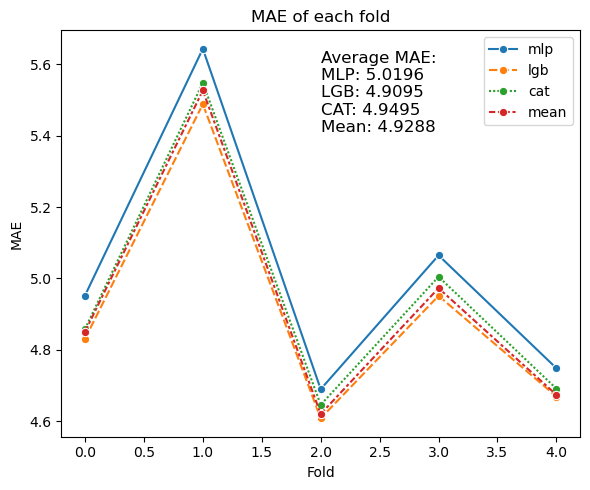

In [22]:
# plot maes as line chart
valid_maes = np.array(valid_maes)
valid_maes = pd.DataFrame(valid_maes, columns=['mlp', 'lgb', 'cat', 'mean'])

fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=valid_maes, ax=ax, marker='o', )
ax.set_title("MAE of each fold")
ax.set_xlabel("Fold")
ax.set_ylabel("MAE")

txt = [
    "Average MAE:",
    f"MLP: {valid_maes['mlp'].mean():.4f}",
    f"LGB: {valid_maes['lgb'].mean():.4f}",
    f"CAT: {valid_maes['cat'].mean():.4f}",
    f"Mean: {valid_maes['mean'].mean():.4f}", 
    ]
ax.text(0.5, 0.95, "\n".join(txt),
        transform=ax.transAxes, fontsize=12, ha='left', va='top')

fig.tight_layout()
plt.show()

In [24]:
# save models
save_dir = "/home/lishi/projects/Competition/kaggle_2023/data/models_stock_0"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for i, model in enumerate(mlp_models):
    joblib.dump(model, f"{save_dir}/mlp_{i}.pkl")
    
for i, model in enumerate(lgb_models):
    joblib.dump(model, f"{save_dir}/lgb_{i}.pkl")
    
for i, model in enumerate(cat_models):
    joblib.dump(model, f"{save_dir}/cat_{i}.pkl")

In [ ]:


mlp, train_loss_list, test_loss_list = train_mlp(
    mlp_params
    train_df[feature_cols].values, train_df['target'].values, 
    test_df[feature_cols].values, test_df['target'].values, 
    lr=1e-4, 
    epoch=30, 
    batch_size=1000, 
    mom=0.9)

print(f"Best test loss: {np.min(test_loss_list)}")
print(f"Best test epoch: {np.argmin(test_loss_list)}")
print(f"Fianl test loss: {test_loss_list[-1]}")

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0].plot(train_loss_list, label='train')
axes[1].plot(test_loss_list, label='test')
for ax in axes:
    ax.legend()
    ax.grid()
fig.tight_layout()
plt.show()


In [ ]:
model_name = f"mlp_no_ta_add_daily_{len(feature_cols)}_label_{'-'.join([str(x) for x in stock_label])}"
save_dir = f"/home/lishi/projects/Competition/kaggle_2023/data/mlp_models/{model_name}"
scaler_file = f"{save_dir}/{model_name}_scaler.pkl"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_params = {
        'boosting_type': 'gbdt',
        'learning_rate': 0.015, #0.009,#0.018,
        'max_depth': 12,#9,
        'n_estimators': 800,#600,
        'num_leaves': 1024,#440,
        'objective': 'mae',
        'random_state': 42,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01,
        'early_stopping_rounds': 50,
        'num_threads': 16,
        'importance_type': 'gain',
        'verbose': -1,
        }

lgb_model = lgb.LGBMRegressor(**lgb_params)

lgb_model.fit(
        train_df[feature_cols], 
        train_df['target'],
        eval_set=[(test_df[feature_cols], test_df['target'])],
        feature_name = feature_cols,
        categorical_feature = category,
        callbacks=[lgb.callback.log_evaluation(period=100)],
        )


In [ ]:
print("LightGBM model training completed!")
print(f"Best iteration: {lgb_model.best_iteration_}")
print(f"Best score: {lgb_model.best_score_['valid_0']['l1']}")
print(f"Final score: {lgb_model.score(test_df[feature_cols], test_df['target'])}")
print(f"Number of iterations: {lgb_model.n_estimators_}")


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_metric(lgb_model, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
lgb.plot_importance(lgb_model, ax=ax, max_num_features=30)
plt.show()